In [1]:
from keras.layers import Input,Dense,Embedding,Lambda,TimeDistributed,LSTM, Reshape, Dropout
from keras.models import Model
from TransformerEncoder import TransformerEncoder
from TrainablePositionalEmbeddings import TransformerPositionalEmbedding
import os
import pickle
from sklearn.model_selection import train_test_split
from keras.optimizers import Nadam, Adam
from Attention import MultiHeadedAttention
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

Using TensorFlow backend.


## data processing

In [4]:
data_df = pd.read_csv('data/sku_week_20191024_v2.csv')

In [6]:
c1_list = [58465, 25249, 36520]
a3_list = [30851, 59546, 32194, 31621, 48341]

In [7]:
key_df = data_df[data_df['sku_id'].isin(c1_list) | data_df['sku_id'].isin(a3_list)]

In [11]:
key_df['y'].median()

434.3045000000001

24211.944

## Model

In [4]:
input_seq_len = 16
input_dim = 1
hidden_dim = 100
positional_ff_dim = 256
dropout_rate = 0.1
output_seq_len = 1
output_dim = 1

output_dir = './output'

In [7]:
def time_series_model_LSTM_Transformer():
    
    encoder_inputs = Input((input_seq_len,input_dim,),dtype='float32',name='Encoder_input')
#     encoder = [LSTM(hidden_dim,return_state=True,return_sequences=True,name='Encoder'+str(i)) for i in range(num_layers)]
    
    positional_embedding_layer    = TransformerPositionalEmbedding(name='Positional_embedding')
    next_step_input               = positional_embedding_layer(encoder_inputs)
    
    next_step_input,attention =TransformerEncoder(hidden_dim,
                                                             2,
                                                             hidden_dim,
                                                             hidden_dim,
                                                             positional_ff_dim,
                                                             dropout_rate= 0.1,
                                                             name= 'Transformer')(next_step_input)
    '''
    next_step_input,attention =TransformerEncoder(hidden_dim,
                                                         2,
                                                         hidden_dim,
                                                         hidden_dim,
                                                         positional_ff_dim,
                                                         dropout_rate= 0.1,
                                                         name= 'Transformer1')(next_step_input)
    
    
    next_step_input,attention =TransformerEncoder(hidden_dim,
                                                         2,
                                                         hidden_dim,
                                                         hidden_dim,
                                                         positional_ff_dim,
                                                         dropout_rate= 0.1,
                                                         name= 'Transformer2')(next_step_input)
    '''
    
    
    
    
    state_h = Lambda(lambda x : x[:,0, :] )(next_step_input)
    state_c = Lambda(lambda x : x[:,1, :] )(next_step_input)
    
    #print(state_h)
    decoder_inputs = Input(tensor=encoder_inputs[:,-(output_seq_len):,:])
    decoder = LSTM(hidden_dim,return_sequences=True,return_state=True,name='Decoder')
    predicted_values,_,_ = decoder(decoder_inputs,initial_state = [state_h,state_c])
#     print(predicted_values)
#     predicted_values = Lambda(lambda x : x[:,:output_seq_len, :] )(next_step_input)
    reshaped_outputs = TimeDistributed(Dense(output_dim))(predicted_values)
    #next_step_input = Lambda(lambda x: x[:,0])(next_step_input)
    #reshaped_outputs = Dense(output_dim)(next_step_input)
    
    #predicted_values, _, _ = decoder(next_step_input)
    #print(predicted_values)
    #predicted_values = Lambda(lambda x: x[:,0])(predicted_values)
    #reshaped_outputs = Dense(output_dim)(predicted_values)
    
    return Model(inputs= [encoder_inputs,decoder_inputs],output=[reshaped_outputs])
    #return Model(inputs=[encoder_inputs], output = [reshaped_outputs])

In [171]:
def LSTM_time_series_model():
    inputs = Input((input_seq_len,input_dim,))
    x = LSTM(hidden_dim, return_sequences=True)(inputs)
    attention_layer = MultiHeadedAttention(hidden_dim,1,hidden_dim,hidden_dim,0.1, name='ATT')
    x, _ = attention_layer(x)
    x = Dropout(0.1)(x)
    #x = Lambda(lambda x: x[:,0])(x)
    x = Dense(output_dim)(x)
    x = Reshape((input_seq_len,))(x)
    outputs = Dense(output_dim)(x)
    
    
    return Model(inputs=[inputs], output = [outputs])
    
    
    

In [99]:
model = LSTM_time_series_model()

/home/adonis/.keras/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  del sys.path[0]


In [8]:
model = time_series_model_LSTM_Transformer()

/Users/zxy/project/.keras/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


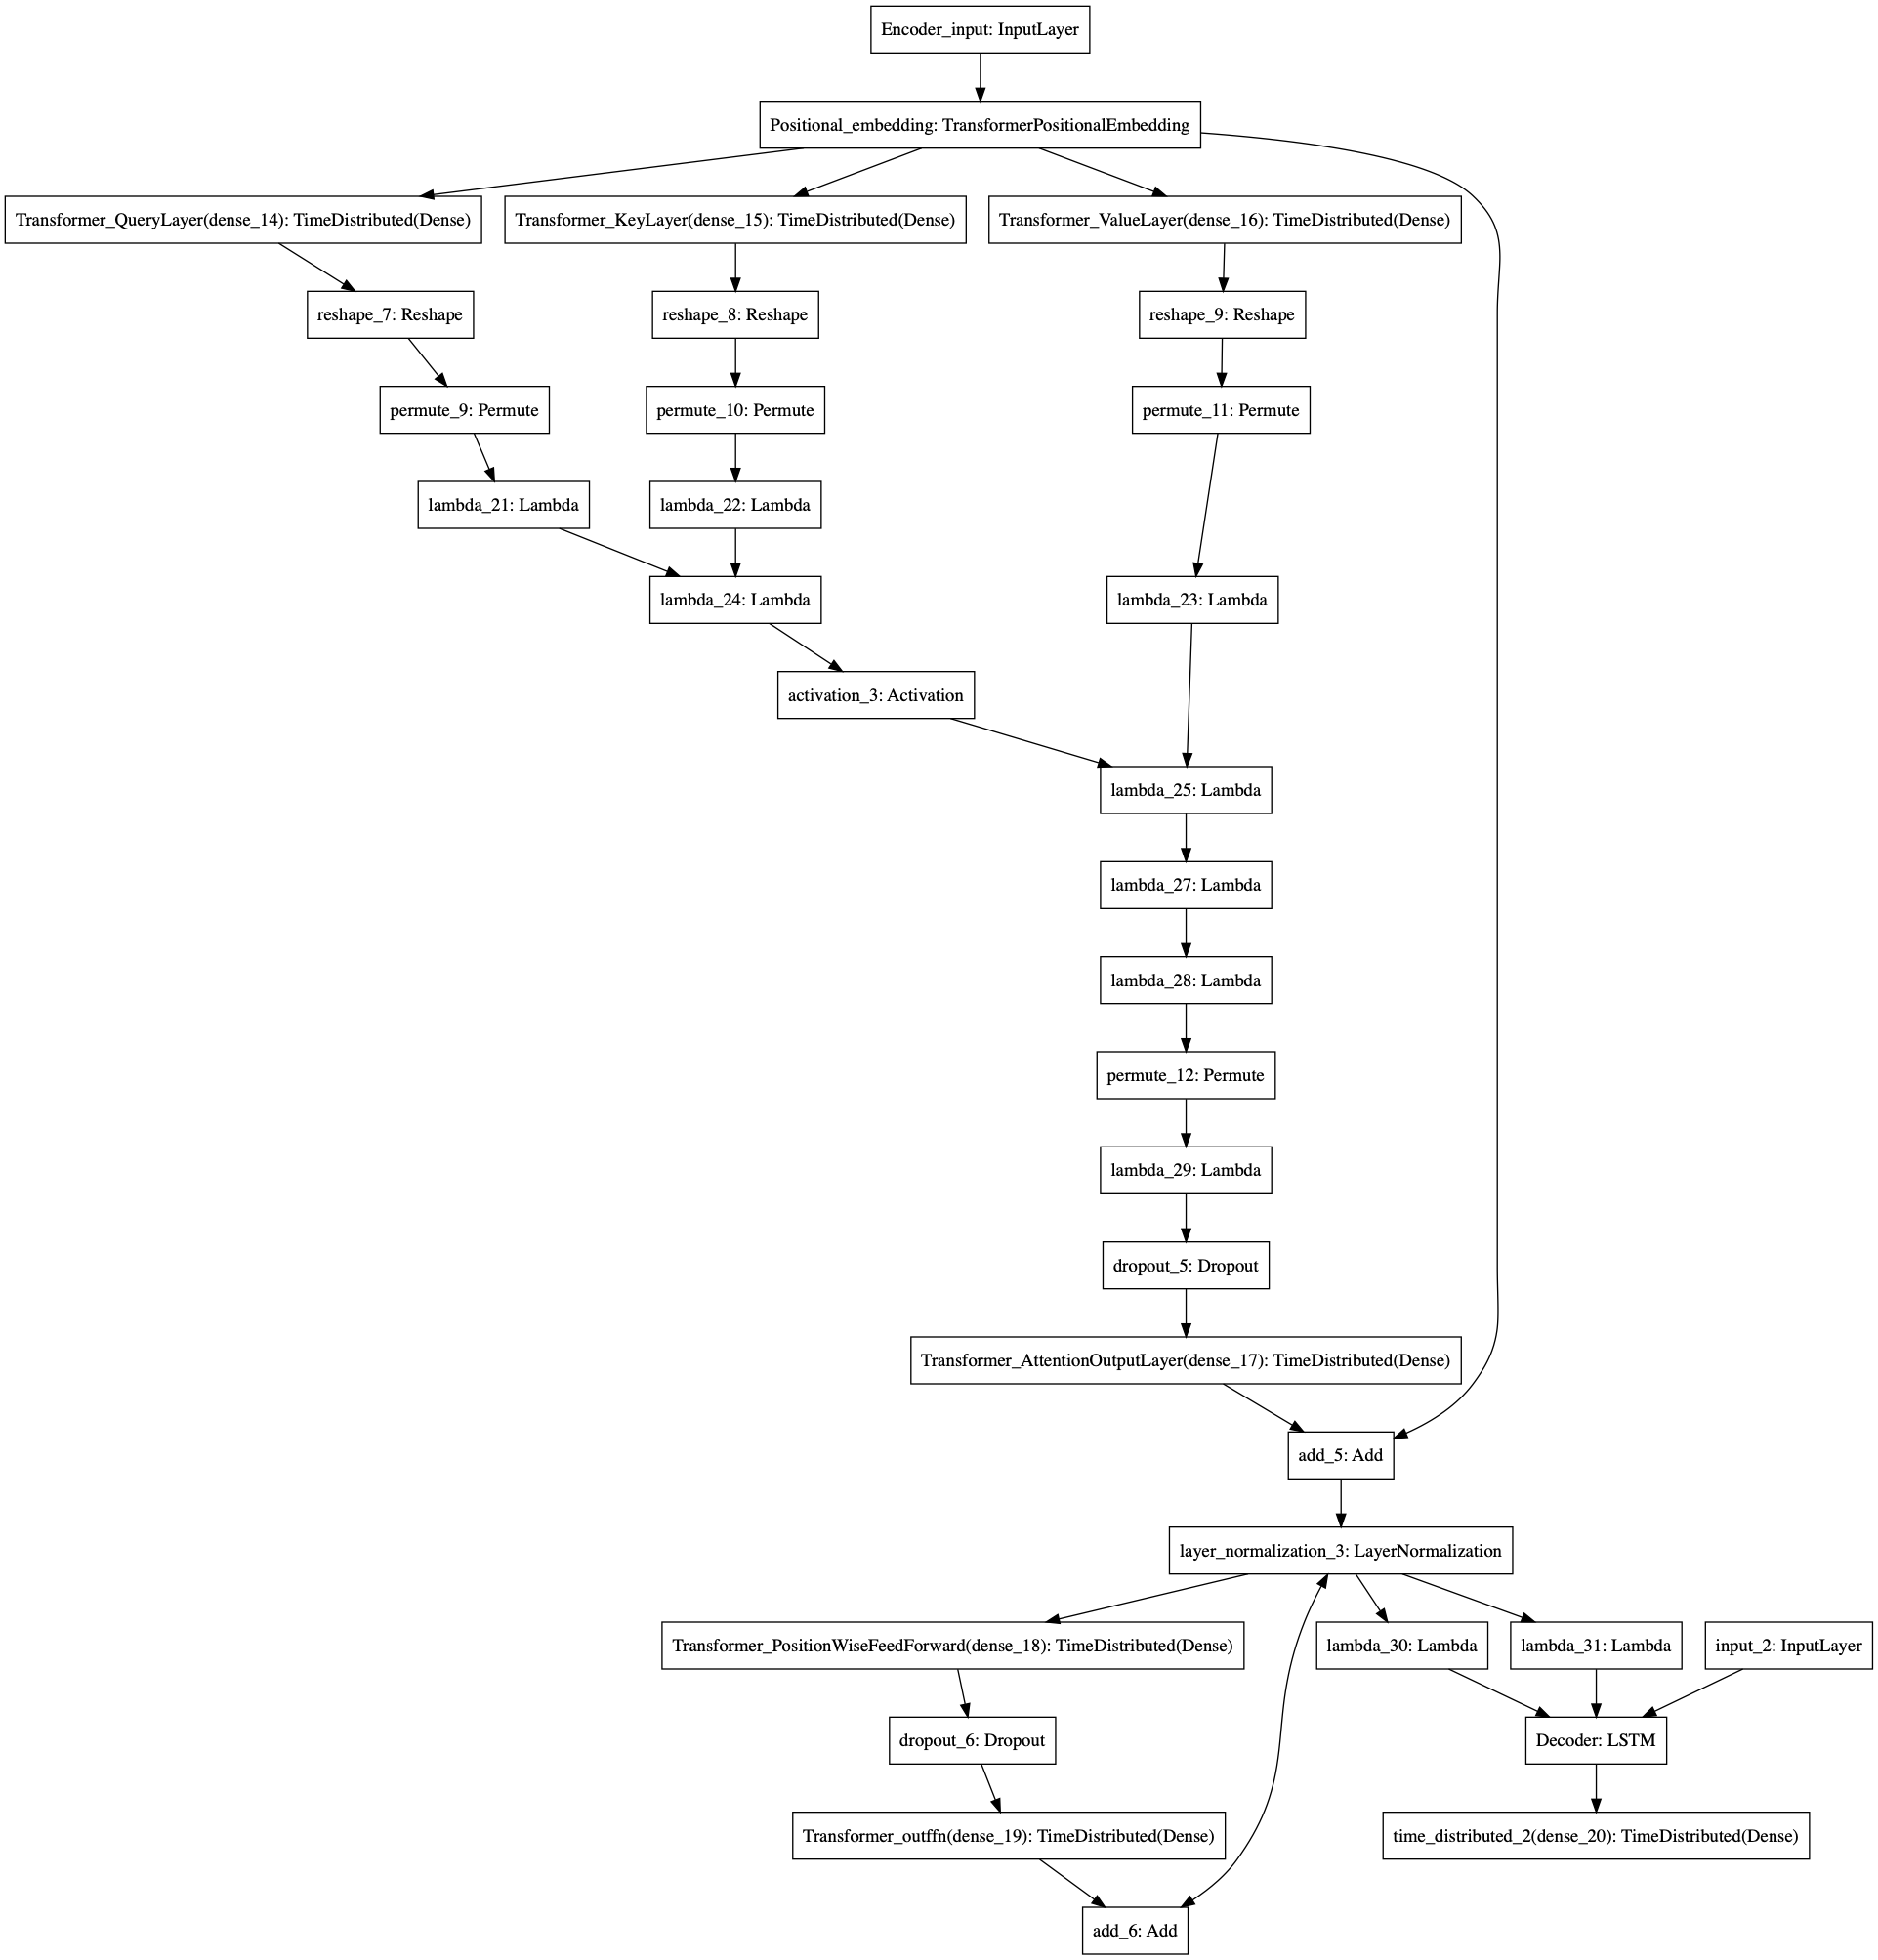

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', expand_nested=True)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      (None, 16, 1)        0                                            
__________________________________________________________________________________________________
Positional_embedding (Transform (None, 16, 1)        16          Encoder_input[0][0]              
__________________________________________________________________________________________________
Transformer_QueryLayer (TimeDis (None, 16, 200)      200         Positional_embedding[0][0]       
__________________________________________________________________________________________________
Transformer_KeyLayer (TimeDistr (None, 16, 200)      200         Positional_embedding[0][0]       
____________________________________________________________________________________________

In [22]:
model.compile(optimizer=Nadam(), loss='mean_squared_error')

In [13]:
with open('data/SKU_30851_data.pkl','rb') as f:
    data = pickle.load(f)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data_train, data_test = train_test_split(data, test_size=0.05, random_state=42)
x_train = data_train[:,:-1]
y_train = data_train[:,-1]
x_test = data_test[:,:-1]
y_test = data_test[:,-1]

x_train = x_train.reshape(y_train.shape[0],16,1)
x_test = x_test.reshape(y_test.shape[0],16,1)

y_train = y_train.reshape(y_train.shape[0],1,1)
y_test = y_test.reshape(y_test.shape[0],1,1)


In [14]:
history = model.fit(x_train,y_train, epochs=300)

Epoch 1/300
203/203 [==============================] - 1s 6ms/step - loss: 1.0961
Epoch 2/300
203/203 [==============================] - 0s 571us/step - loss: 0.0580
Epoch 3/300
203/203 [==============================] - 0s 557us/step - loss: 0.0522
Epoch 4/300
203/203 [==============================] - 0s 537us/step - loss: 0.0615
Epoch 5/300
203/203 [==============================] - 0s 526us/step - loss: 0.0481
Epoch 6/300
203/203 [==============================] - 0s 545us/step - loss: 0.0471
Epoch 7/300
203/203 [==============================] - 0s 528us/step - loss: 0.0517
Epoch 8/300
203/203 [==============================] - 0s 532us/step - loss: 0.0442
Epoch 9/300
203/203 [==============================] - 0s 534us/step - loss: 0.0505
Epoch 10/300
203/203 [==============================] - 0s 535us/step - loss: 0.0474
Epoch 11/300
203/203 [==============================] - 0s 531us/step - loss: 0.0501
Epoch 12/300
203/203 [==============================] - 0s 542us/step - loss

In [23]:
model.evaluate(x_test, y_test)

11/11 [==============================] - 0s 16ms/step


0.02549031935632229

In [276]:
pred = model.predict(x_test)

In [277]:
pred = pred.reshape(y_test.shape[0],)

In [278]:
pred

array([0.18846312, 0.12933911, 0.13643132, 0.1417519 , 0.148172  ,
       0.08519126, 0.08631994, 0.04738076, 0.03923615, 0.5686521 ,
       0.07338565], dtype=float32)

In [218]:
pred = np.concatenate((pred, np.array([0.0]*6)), axis=0)

In [222]:
y_test = np.concatenate((y_test.reshape(y_test.shape[0],), np.array([0.0]*6)), axis=0)

In [205]:
y_test.reshape(y_test.shape[0],)

array([0.41632653, 0.00734694, 0.29183673, 0.22040816, 0.49102041,
       0.09959184, 0.06      , 0.21428571, 0.01387755, 0.83061224,
       0.0477551 ])

In [220]:
scaler.inverse_transform(pred.reshape(1,-1))

array([[3170.05202937, 2516.40255368, 2734.9455083 , 1980.66542333,
        3499.70189613,  897.50326225, 2756.4945091 , 2925.22723782,
        2742.4194907 , 8159.13222241, 2267.52483058,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ]])

In [223]:
scaler.inverse_transform(y_test.reshape(1,-1))

array([[ 6609.6 ,   116.64,  4633.2 ,  3499.2 ,  7795.44,  1581.12,
          952.56,  3402.  ,   220.32, 13186.8 ,   758.16,     0.  ,
            0.  ,     0.  ,     0.  ,     0.  ,     0.  ]])

In [180]:
import numpy as np

In [279]:
acc = 1 - np.mean(abs(pred - y_test.reshape(y_test.shape[0],)) / (y_test.reshape(y_test.shape[0],)+0.01))

In [280]:
acc

-0.10695593344954979

In [192]:
abs(pred - y_test.reshape(24,))# / (y_test.reshape(24,))

array([0.89205315, 0.87075845, 0.24585865, 0.03594618, 1.60796462,
       0.14524652, 0.11866554, 0.30949681, 1.99716268, 0.48063638,
       0.93649645, 0.22187629, 1.64933452, 1.38795963, 0.44200471,
       1.02982953, 1.07476275, 0.6195276 , 1.02828431, 0.23644275,
       0.98890043, 0.95346081, 0.96893199, 0.37468421])

In [20]:
model.load_weights('./model.h5')

In [27]:
layer = Embedding(5,6)
layer.get_config()

{'name': 'embedding_1',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 5,
 'output_dim': 6,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}